In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings

#Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 11

print("Libraries ready")

Libraries ready


In [23]:
#Obtaining the data
fWater = "1548EA3_ALL_LATEST.csv"  
fMort  = "ED50112_ALL_LATEST.csv" 

#We use a try in order to load the data
#If there is a issue, we can know what's going on 
try:
    water = pd.read_csv(fWater,encoding='utf-8')
    print("Water: ready")
except ValueError as ve:
    print(f"There was an error: {ve}")

try:
    mort = pd.read_csv(fMort,encoding='utf-8')
    print("Mortality: ready")
except ValueError as ve:
    print(f"There was an error: {ve}")  


Water: ready
Mortality: ready


In [24]:
#Obtaining the data
fWater = "1548EA3_ALL_LATEST.csv"  
fMort  = "ED50112_ALL_LATEST.csv" 

#We use a try in order to load the data
#If there is a issue, we can know what's going on 
try:
    water = pd.read_csv(fWater,encoding='utf-8')
    print("Water: ready")
except ValueError as ve:
    print(f"There was an error: {ve}")

try:
    mort = pd.read_csv(fMort,encoding='utf-8')
    print("Mortality: ready")
except ValueError as ve:
    print(f"There was an error: {ve}")  


Water: ready
Mortality: ready


In [25]:
#Create a function to clean data
def advancedDataCleaning(df, datasetName = "dataset"):
    print(f"Advanced cleaning: {datasetName} ===")
    print(f"Before: {df.shape}")

    #Remove empty rows
    #We use dropna(how: all) because if all values are NA, drop that row or column 
    dfClean = df.dropna(how='all')
    print(f"After eliminating empty row: {dfClean.shape}")
    
    #Remove columns with 33% empty values
    limit = 0.33 * len(dfClean)
    #We count the columns where they are less than 33
    colsToKeep = dfClean.columns[dfClean.isna().sum() <= limit]
    dfClean = dfClean.loc[:,colsToKeep]
    print(f"After eliminating columns with > 33% null: {dfClean.shape}")

    #Remove duplicates
    dfClean = dfClean.drop_duplicates()
    print(f"After eliminating duplicates values: {dfClean.shape}")

    #Impute missing numeric values ​​with mean
    #We use select_dtypes in order to have a subset of the DataFrame's columns 
    #We use number to select all numeric types
    #Also, at the end we use .columns to know the names of the columns
    numCols = dfClean.select_dtypes(include='number').columns
    for col in numCols:
        #We count the null values
        #dfClean[col].isna() -> True where there are NaN
        #.sum() how many trues we have
        if dfClean[col].isna().sum() > 0:
            meanVal = dfClean[col].mean()
            dfClean[col] = dfClean[col].fillna(meanVal)
            print(f"Imputed {col} with a media of: {meanVal:.2f}")

    #Mode
    catCols = dfClean.select_dtypes(include='object').columns
    for col in catCols:
        if dfClean[col].isna().sum() > 0:
            modeVal = dfClean[col].mode()[0] if not dfClean[col].mode().empty else "UNKNOWN"
            dfClean[col] = dfClean[col].fillna(modeVal)
            print(f"Imputed {col} with a mode; {modeVal}")

    print(f"Final form: {dfClean.shape}")
    print(dfClean.isna().sum().sum())

    return dfClean
print("\n" + "="*60)
water = advancedDataCleaning(water, "AGUA")
print("\n" + "="*60)
mort = advancedDataCleaning(mort, "MORTALIDAD")



Advanced cleaning: AGUA ===
Before: (7080, 13)
After eliminating empty row: (7080, 13)
After eliminating columns with > 33% null: (7080, 13)
After eliminating duplicates values: (7080, 13)
Imputed PERCENT_POP_N with a media of: 58.76
Final form: (7080, 13)
0

Advanced cleaning: MORTALIDAD ===
Before: (552, 13)
After eliminating empty row: (552, 13)
After eliminating columns with > 33% null: (552, 13)
After eliminating duplicates values: (552, 13)
Final form: (552, 13)
0


In [26]:
def standardizeWhoData(df, valueAlias, dataset_type="water"):
    if dataset_type == "water":
        colsMap = {
            'GEO_NAME_SHORT': 'country',
            'DIM_TIME': 'year',
            'PERCENT_POP_N': valueAlias,
            'DIM_DEG_URB': 'urbanization',
            'DIM_GEO_CODE_TYPE': 'geo_type'
        }
    else:
        colsMap = {
            'GEO_NAME_SHORT': 'country',
            'DIM_TIME': 'year',
            'RATE_PER_100000_N': valueAlias,
            'DIM_SEX': 'sex',
            'DIM_GEO_CODE_TYPE': 'geo_type'
        }
    
    available = [c for c in colsMap.keys() if c in df.columns]
    out = df[available].copy()
    out.columns = [colsMap[c] for c in available]

    #Convert argument to a numeric type    
    out['year'] = pd.to_numeric(out['year'], errors='coerce').astype('Int64')
    out[valueAlias] = pd.to_numeric(out[valueAlias], errors='coerce')
    
    out = out.dropna(subset=['country', 'year', valueAlias])
    out = out.drop_duplicates().reset_index(drop=True)
    
    if dataset_type == "water":
        out = out[(out[valueAlias] >= 0) & (out[valueAlias] <= 100)]
    else:
        out = out[out[valueAlias] >= 0]
    
    return out

waterStd = standardizeWhoData(water, "water_pct", "water")
mortStd = standardizeWhoData(mort, "wash_mortality_per_100k", "mortality")

print(f"Agua estandarizada: {waterStd.shape}")
print(f"Mortalidad estandarizada: {mortStd.shape}")

Agua estandarizada: (7080, 5)
Mortalidad estandarizada: (552, 5)



=== EDA VISUALIZATION ===


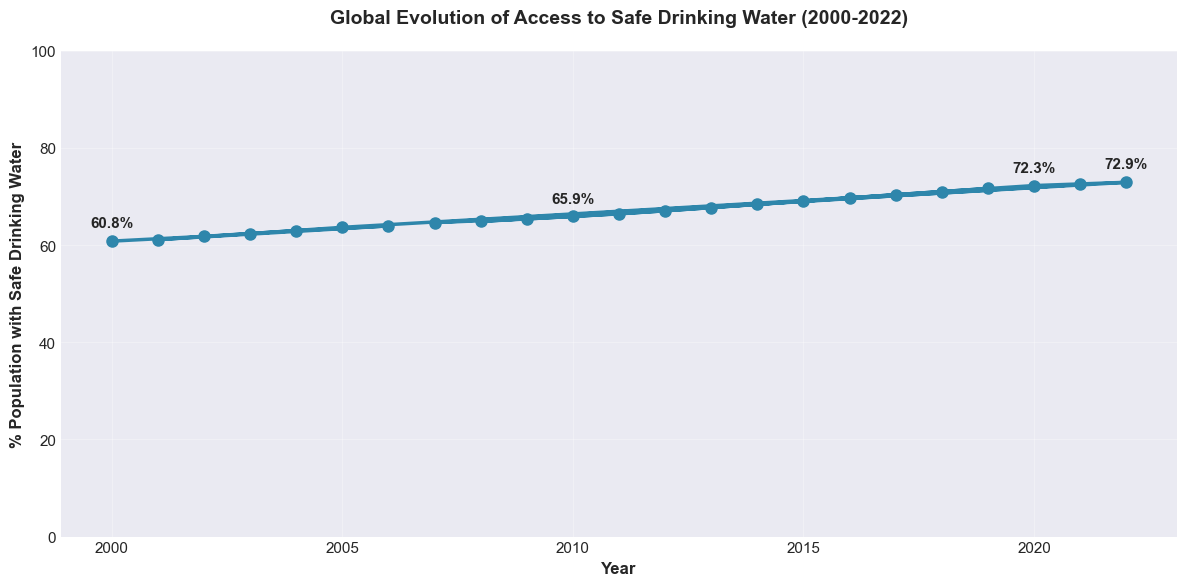

2000-2022: 60.8% -> 72.9%(+12.1points)


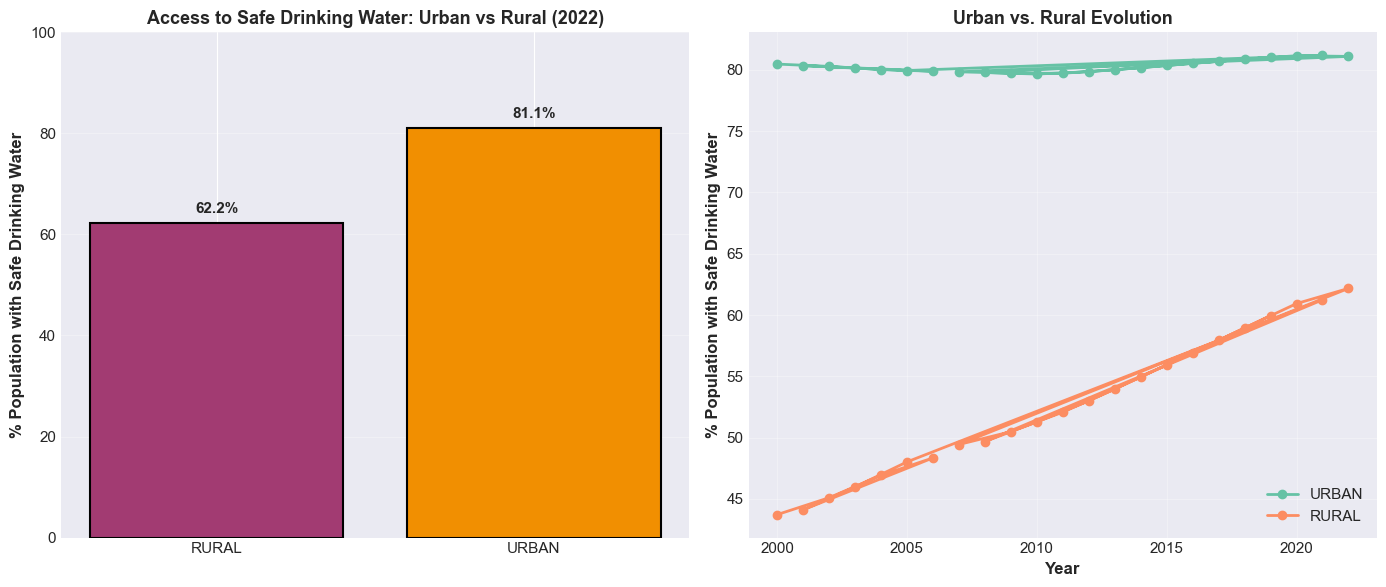

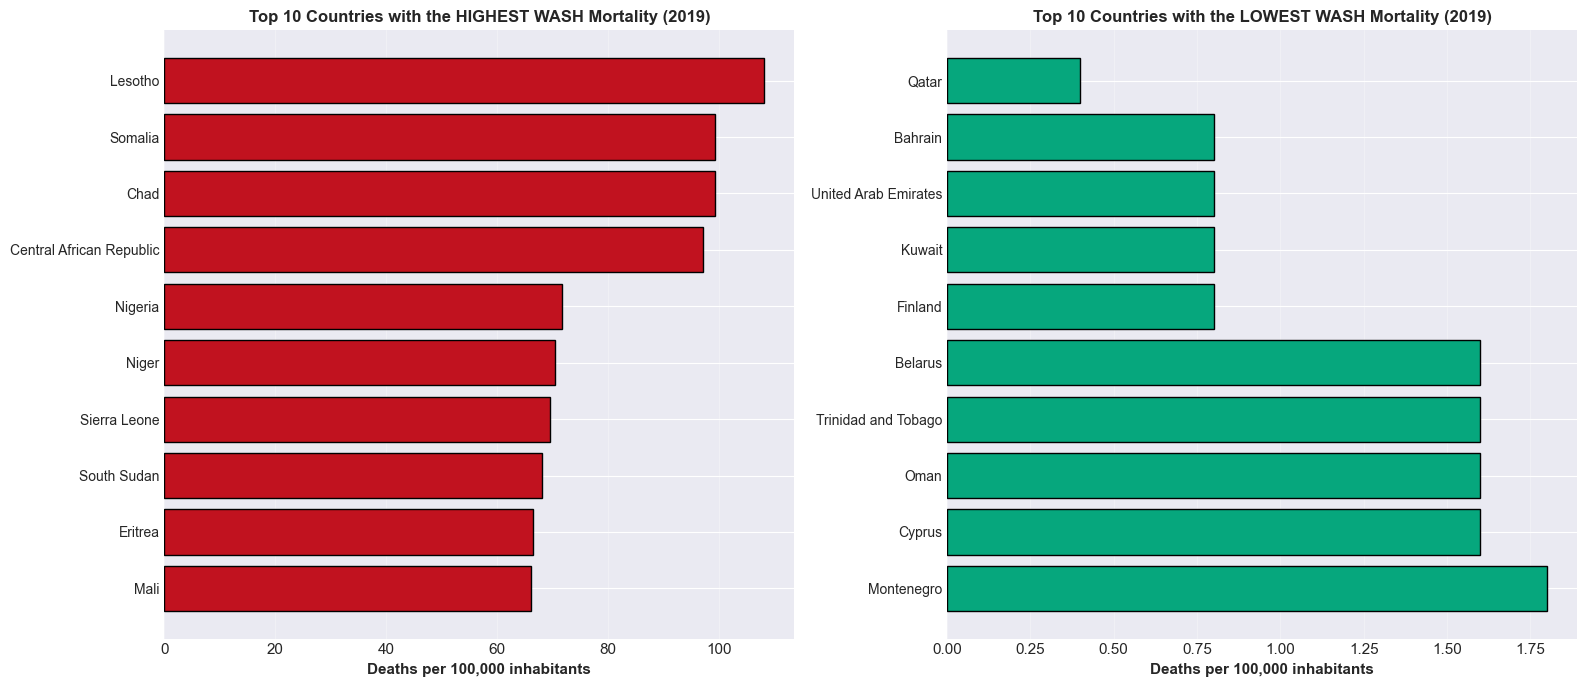

Country with highest mortality: Lesotho (108.1/100k)
Country with lowest mortality: Qatar (0.400/100k)


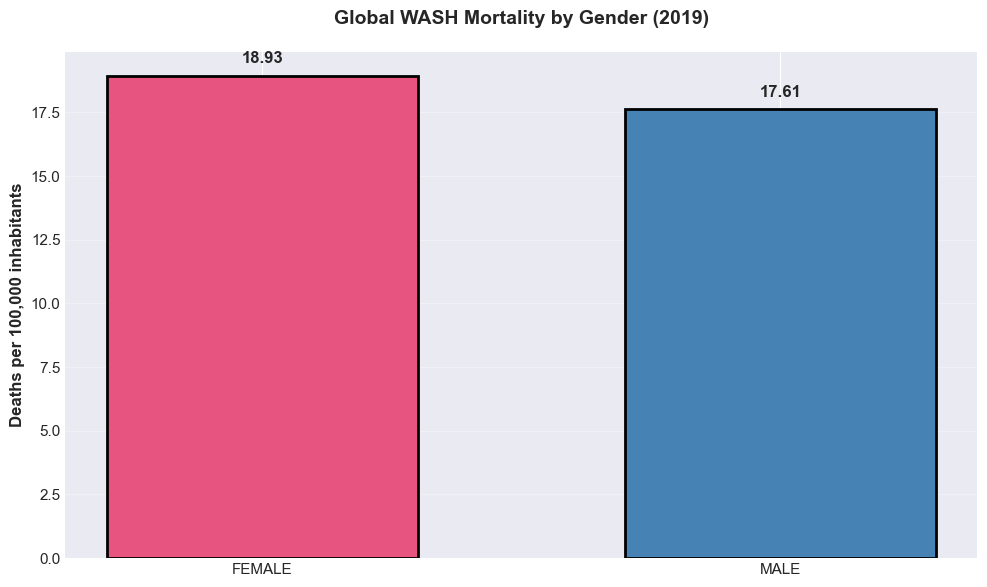

Difference between genders: 1.32 deaths/100k


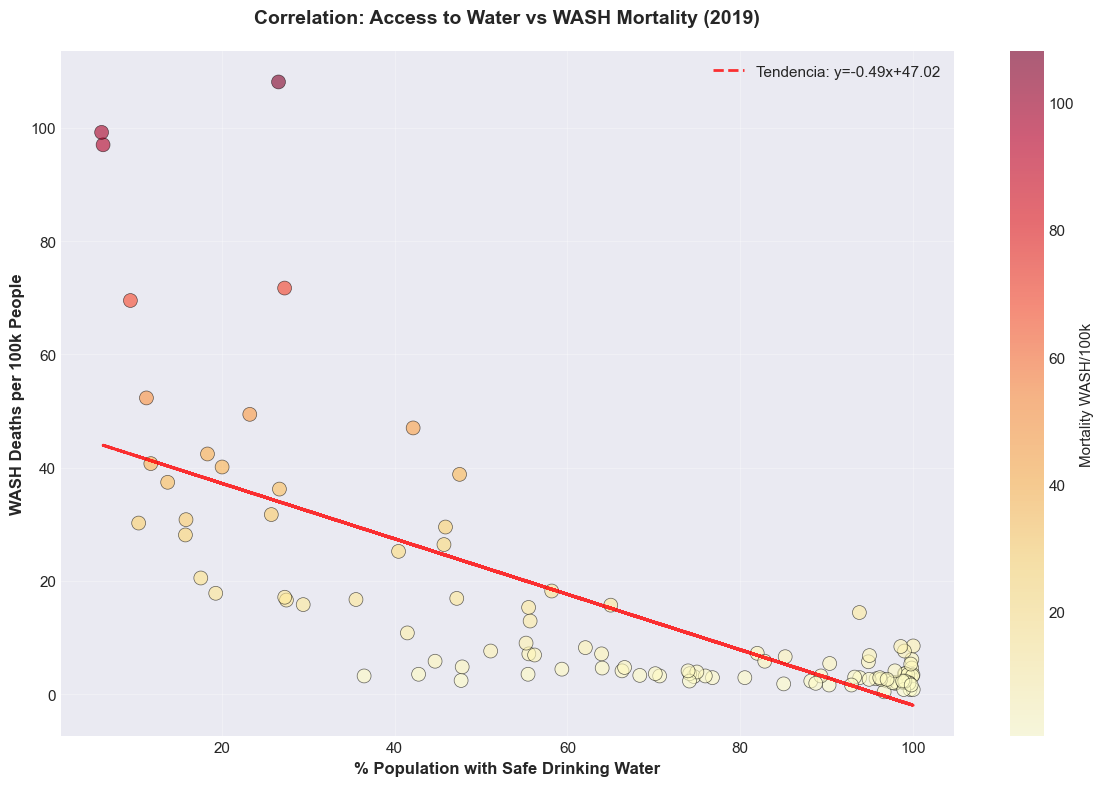

Pearson correlation: -0.718
   → STRONG NEGATIVE correlation: More safe water = Lower mortality


In [27]:
print("\n" + "="*60)
print("=== EDA VISUALIZATION ===")

#We only take take global level and total
waterGlobal = waterStd[(waterStd['geo_type'] == 'GLOBAL') & (waterStd['urbanization'] == 'TOTAL')].copy()
#Create a figure
fig, ax = plt.subplots(figsize=(12,6))

#Lineal chart
ax.plot(
    waterGlobal['year'],    #X -> years
    waterGlobal['water_pct'], #Y -> %drinking water
    marker = 'o', #point
    linewidth=2.5,
    markersize=8, #size
    color='#2E86AB'
)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
ax.set_title(
    'Global Evolution of Access to Safe Drinking Water (2000-2022)',
    fontsize=14, fontweight='bold', pad=20
)
ax.grid(True, alpha=0.3) 
ax.set_ylim([0,100]) #percentages

for year in [2000, 2010, 2020, 2022]:
    #Select the row for that year
    row = waterGlobal[waterGlobal['year'] == year]
    #This ensures that if the dataset doesn’t have data for a given year, the code skips it
    if not row.empty:
        #Extract the percentage value
        val = row['water_pct'].values[0] #Wr take the value calculated
        #We plot the the year and value in order to see how's changing 
        ax.annotate(f'{val:.1f}%', xy=(year, val), xytext=(0, 10), 
                    textcoords='offset points', ha='center', fontweight='bold')
#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

initial = waterGlobal[waterGlobal['year'] == 2000]['water_pct'].values[0]
end = waterGlobal[waterGlobal['year'] == 2022]['water_pct'].values[0]
print(f"2000-2022: {initial:.1f}% -> {end:.1f}%(+{end-initial:.1f}points)")

#Urban vs rural
water2022 = waterStd[(waterStd['year'] == 2022) & (waterStd['geo_type'] == 'GLOBAL') & (waterStd['urbanization'].isin(['URBAN','RURAL']))]
fig, axes = plt.subplots(1,2, figsize=(14,6))

axes[0].bar(water2022['urbanization'], water2022['water_pct'], color=['#A23B72', '#F18F01'], edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
axes[0].set_title('Access to Safe Drinking Water: Urban vs Rural (2022)', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)

for i,(urb,pct) in enumerate(zip(water2022['urbanization'],water2022['water_pct'])):
    axes[0].text(i, pct + 2, f'{pct:.1f}%', ha='center', fontweight='bold', fontsize=11)

waterUrbTime = waterStd[(waterStd['geo_type'] == 'GLOBAL') & (waterStd['urbanization'].isin(['URBAN', 'RURAL']))]

#Plot two series Urban and Rural
for urb in ['URBAN', 'RURAL']:
    #Filter time series
    data = waterUrbTime[waterUrbTime['urbanization'] == urb]
    #Drawing a line 
    axes[1].plot(data['year'], data['water_pct'], marker='o', label=urb, linewidth=2)

axes[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axes[1].set_ylabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
axes[1].set_title('Urban vs. Rural Evolution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

#Top 10 mortality
mortCountries = mortStd[(mortStd['geo_type'] == 'COUNTRY') & (mortStd['sex'] == 'TOTAL')].copy()
top10Worst = mortCountries.nlargest(10,'wash_mortality_per_100k')
top10Best = mortCountries.nsmallest(10,'wash_mortality_per_100k')
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

#Chart configuration Highest mortality
axes[0].barh(range(10), top10Worst['wash_mortality_per_100k'], color='#C1121F', edgecolor='black')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top10Worst['country'], fontsize=10)
axes[0].set_xlabel('Deaths per 100,000 inhabitants', fontsize=11, fontweight='bold')
axes[0].set_title('Top 10 Countries with the HIGHEST WASH Mortality (2019)', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

#Lowest mortality
#Draw a line for the 10 countries with the lowest mortality
axes[1].barh(range(10), top10Best['wash_mortality_per_100k'], color='#06A77D', edgecolor='black')
axes[1].set_yticks(range(10))
#Label each bar with the corresponding country name
axes[1].set_yticklabels(top10Best['country'], fontsize=10)
axes[1].set_xlabel('Deaths per 100,000 inhabitants', fontsize=11, fontweight='bold')
axes[1].set_title('Top 10 Countries with the LOWEST WASH Mortality (2019)', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

print("Country with highest mortality:", top10Worst.iloc[0]['country'], f"({top10Worst.iloc[0]['wash_mortality_per_100k']:.1f}/100k)")
print("Country with lowest mortality:", top10Best.iloc[0]['country'], f"({top10Best.iloc[0]['wash_mortality_per_100k']:.3f}/100k)")

#Genre
mortGender = mortStd[(mortStd['geo_type'] == 'GLOBAL') & (mortStd['sex'].isin(['FEMALE', 'MALE']))]
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'FEMALE': '#E75480', 'MALE': '#4682B4'}
for sex in ['FEMALE', 'MALE']:
    data = mortGender[mortGender['sex'] == sex]
    ax.bar(sex, data['wash_mortality_per_100k'].values[0], color=colors[sex], edgecolor='black', linewidth=2, width=0.6)
    ax.text(sex, data['wash_mortality_per_100k'].values[0] + 0.5, f"{data['wash_mortality_per_100k'].values[0]:.2f}", ha='center', fontweight='bold', fontsize=12)

ax.set_ylabel('Deaths per 100,000 inhabitants', fontsize=12, fontweight='bold')
ax.set_title('Global WASH Mortality by Gender (2019)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

#Adjust the padding between and around subplots
plt.tight_layout()
plt.show()

diff = abs(mortGender[mortGender['sex']=='FEMALE']['wash_mortality_per_100k'].values[0] - mortGender[mortGender['sex']=='MALE']['wash_mortality_per_100k'].values[0])
print(f"Difference between genders: {diff:.2f} deaths/100k")

water2019Contries = waterStd[(waterStd['year'] == 2019) & (waterStd['geo_type'] == 'COUNTRY') & (waterStd['urbanization'] == 'TOTAL')][['country', 'water_pct']]
mort2019Contries =  mortStd[(mortStd['geo_type'] == 'COUNTRY') & (mortStd['sex'] == 'TOTAL')][['country', 'wash_mortality_per_100k']]
merged = pd.merge(water2019Contries, mort2019Contries, on='country', how='inner')

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(merged['water_pct'], merged['wash_mortality_per_100k'], alpha=0.6, s=100, c=merged['wash_mortality_per_100k'], cmap='YlOrRd', edgecolors='black', linewidth=0.5)
z = np.polyfit(merged['water_pct'], merged['wash_mortality_per_100k'], 1)
p = np.poly1d(z)
ax.plot(merged['water_pct'], p(merged['water_pct']), "r--", alpha=0.8, linewidth=2, label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.2f}')
ax.set_xlabel('% Population with Safe Drinking Water', fontsize=12, fontweight='bold')
ax.set_ylabel('WASH Deaths per 100k People', fontsize=12, fontweight='bold')
ax.set_title('Correlation: Access to Water vs WASH Mortality (2019)', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.colorbar(scatter, ax=ax, label='Mortality WASH/100k')
plt.tight_layout()
plt.show()
corr = merged['water_pct'].corr(merged['wash_mortality_per_100k'])
print(f"Pearson correlation: {corr:.3f}")
if corr < -0.7:
    print("   → STRONG NEGATIVE correlation: More safe water = Lower mortality")
elif corr < -0.3:
    print("   → MODERATE NEGATIVE correlation")
else:
    print("   → WEAK correlation")
